In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

data = pd.read_csv("data_superstar_v1_0.csv", delimiter=",")
data['date'] = pd.to_datetime(data['release_date'])
data.sort_values(by="date", inplace=True)


# Drop columns not in the list
data["explicit"] = data["explicit"].astype(int)


def find_min_max(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number'])

    # Find max and min values for each numeric column
    min_max_values = {}
    for col in numeric_cols.columns:
        min_value = df[col].min()
        max_value = df[col].max()
        min_max_values[col] = {'min': min_value, 'max': max_value}

    return min_max_values


min_max_val = find_min_max(data)

y = data["hit"]
X = data.drop(columns=["hit", "song_popularity", "date", "release_date", "name_x", "name_y", "song_id", "song_name", "artist1_id", "artist2_id", "song_type"])


def preprocess(df, min_max_values, exclude_cols=None):
    missing_numerical = df.select_dtypes(include=['number']).isnull().sum()
    # Fill missing values with mean for each numeric attribute
    imputer = SimpleImputer(strategy='mean')
    df_filled = df.copy()
    for col in missing_numerical.index:
        if missing_numerical[col] > 0:
            df_filled[col] = imputer.fit_transform(df[[col]])

    # Normalize numerical features into [0, 1] range with MinMaxScaler
    if exclude_cols:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns.difference(exclude_cols)
    else:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns

    # print("numerical columns:", numerical_cols)

    for column_name in numerical_cols:
        df_filled[column_name] = (df_filled[column_name] - min_max_values[column_name]["min"]) / (
                min_max_values[column_name]["max"] - min_max_values[column_name]["min"])

    df_normalized = pd.DataFrame(df_filled, columns=numerical_cols)

    if exclude_cols:
        categorical_cols = df.select_dtypes(include=['object']).columns.difference(exclude_cols)
    else:
        categorical_cols = df.select_dtypes(include=['object']).columns

    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)     #questionable whether true or false

    encoded_columns = [col for col in df_encoded.columns if any(orig_col in col for orig_col in categorical_cols)]

    #print(categorical_cols)

    # Concatenate numerical and encoded categorical features
    df_processed = pd.concat([df_normalized, df_encoded[encoded_columns]], axis=1)

    return df_processed



X_preprocessed = preprocess(X, min_max_val)
X_preprocessed[X_preprocessed.select_dtypes(include=[bool]).columns] = X_preprocessed.select_dtypes(include=[bool]).astype(int)

# split_day = X["date"].iloc[-1] - pd.DateOffset(years=1)
# X_train = X[(X["date"] < split_day)].copy()
# X_test = X[(X["date"] >= split_day)].copy()
# 
# sep_index = X_train.shape[0]
# y_train = y.iloc[:sep_index].copy()
# y_test = y.iloc[sep_index:].copy()
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.25, shuffle=False)

In [2]:
X_train

,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,danceability,...,profile_x_1B 2B 3A 4A,profile_x_No Match,profile_y_1A 2A 3A 4A,profile_y_1A 2A 3A 4B,profile_y_1A 2A 3B 4A,profile_y_1A 2B 3A 4A,profile_y_1A 2B 3A 4B,profile_y_1A 2B 3B 4A,profile_y_1B 2A 3A 4A,profile_y_No Match
0,0.0,0.088710,0.0,1.000000,0.026696,0.909091,1.0,0.8,0.692771,0.181452,...,0,0,0,0,0,0,0,0,0,1
3659,0.0,0.008065,0.0,1.000000,0.057614,0.090909,0.0,0.8,0.298193,0.602823,...,0,0,0,0,0,0,0,0,0,1
3658,0.0,0.032258,0.0,0.025316,0.033897,0.181818,1.0,0.8,0.105422,0.656250,...,0,0,0,0,0,0,0,0,0,1
3657,0.0,0.024194,0.0,0.025316,0.044711,0.636364,1.0,0.8,0.027309,0.782258,...,0,0,0,0,0,0,0,0,0,1
3656,0.0,0.016129,0.0,0.025316,0.039856,0.636364,1.0,0.8,0.025904,0.633065,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683396,0.0,0.153226,0.0,1.000000,0.024570,0.636364,1.0,0.8,0.693775,0.652218,...,0,0,0,0,0,0,0,0,0,1
683430,1.0,0.008065,0.0,1.000000,0.028095,0.727273,0.0,0.8,0.008494,0.818548,...,0,0,0,0,0,0,0,0,0,1
683431,1.0,0.000000,0.0,1.000000,0.028095,0.090909,0.0,0.8,0.092269,0.751008,...,0,0,0,0,0,0,0,0,0,1
683432,0.0,0.016129,0.0,1.000000,0.052731,0.818182,0.0,0.8,0.019980,0.522177,...,0,0,0,0,0,0,0,0,0,1


In [3]:
feature_names = X_preprocessed.columns

In [4]:
feat_name_x_train = X_train.columns

In [5]:
def upsampling(X_train, y_train):
    # Convert y_train to a numpy array
    # y_train = y_train.to_numpy()
    X_train = X_train.to_numpy()

    # Count the number of samples in each class
    class_counts = np.bincount(y_train.flatten().astype(int))
    max_count = class_counts.max()

    # Find indices of positive instances
    positive_indices = np.where(y_train.flatten() == 1)[0]

    # Calculate how many times to duplicate positive samples
    difference = max_count - class_counts[1]

    # Randomly select indices from positive instances
    random_indices = np.random.choice(positive_indices, size=difference, replace=True)

    # Get rows corresponding to positive instances
    rows_to_duplicate = np.vstack([X_train[idx] for idx in random_indices])

    # Stack duplicated rows with the original matrix
    X_train_upsampled = np.vstack([X_train, rows_to_duplicate])

    # Create an array of shape (x, 1) with all elements as 1
    rows_of_ones = np.ones((difference, 1))

    # Append rows_of_ones to original_array
    y_train_upsampled = np.concatenate((y_train, rows_of_ones), axis=0)

    print("######UPSAMPLING DONE######")
    return X_train_upsampled, y_train_upsampled

In [6]:
X_train, y_train = upsampling(X_train, y_train.values.reshape(-1, 1))

######UPSAMPLING DONE######


In [7]:
X_train_df = pd.DataFrame(X_train, columns=feat_name_x_train)
y_train_df = pd.DataFrame(y_train, columns=["hit"])

In [8]:
X_train_df

,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,danceability,...,profile_x_1B 2B 3A 4A,profile_x_No Match,profile_y_1A 2A 3A 4A,profile_y_1A 2A 3A 4B,profile_y_1A 2A 3B 4A,profile_y_1A 2B 3A 4A,profile_y_1A 2B 3A 4B,profile_y_1A 2B 3B 4A,profile_y_1B 2A 3A 4A,profile_y_No Match
0,0.0,0.088710,0.0,1.000000,0.026696,0.909091,1.0,0.8,0.692771,0.181452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.008065,0.0,1.000000,0.057614,0.090909,0.0,0.8,0.298193,0.602823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.032258,0.0,0.025316,0.033897,0.181818,1.0,0.8,0.105422,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.024194,0.0,0.025316,0.044711,0.636364,1.0,0.8,0.027309,0.782258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.016129,0.0,0.025316,0.039856,0.636364,1.0,0.8,0.025904,0.633065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346869,0.0,0.048387,0.0,1.000000,0.033468,0.909091,0.0,0.8,0.005412,0.462702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346870,0.0,0.000000,0.0,1.000000,0.031454,0.000000,1.0,0.8,0.816265,0.512097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346871,0.0,0.072581,0.0,0.987342,0.055808,0.545455,0.0,0.8,0.011747,0.712702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346872,1.0,0.008065,1.0,1.000000,0.036051,0.545455,0.0,0.8,0.114458,0.864919,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\lasse\anaconda3\envs\Ba_first_tries\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


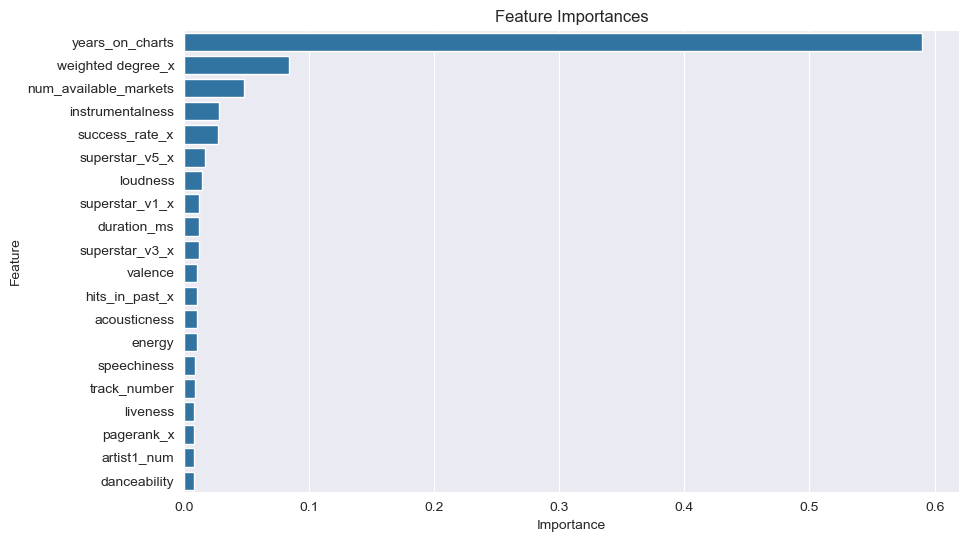

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_df, y_train_df)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.iloc[0:20])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=10)
# plt.tight_layout()

plt.show()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


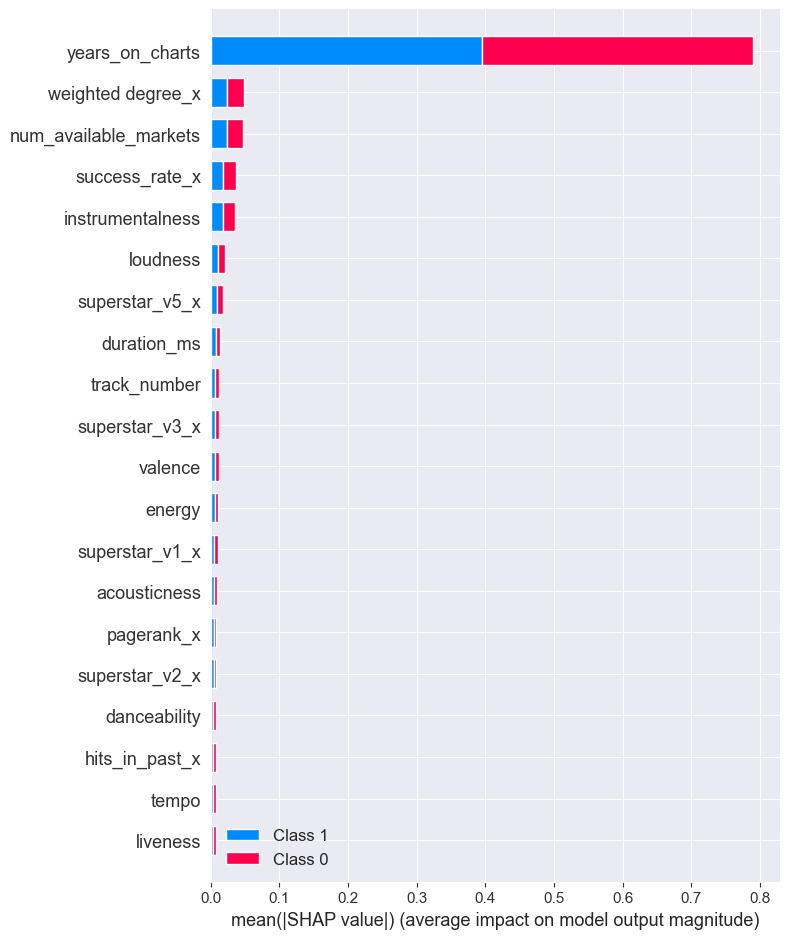

In [10]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df.iloc[:1000])

# Plot the summary plot
shap.summary_plot(shap_values, X_train_df, feature_names=X_train_df.columns)

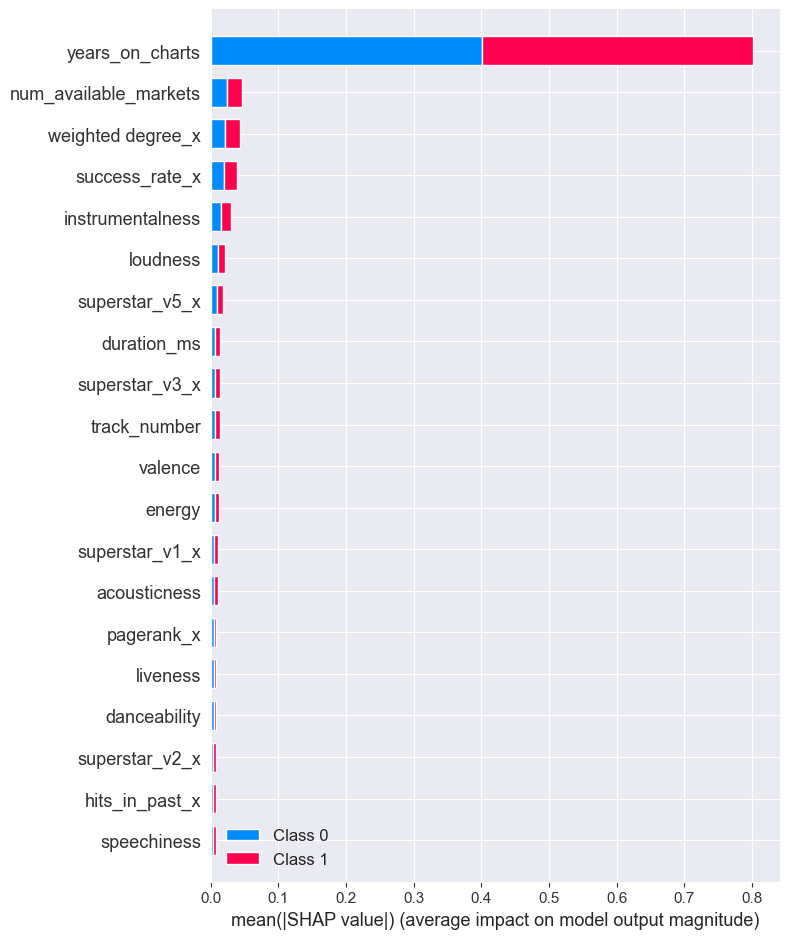

In [11]:
# Calculate SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df.iloc[:10000])

# Plot the summary plot
shap.summary_plot(shap_values, X_train_df, feature_names=X_train_df.columns)

In [12]:
#lolkdsdo

In [13]:
X_train_df.drop(columns=["years_on_charts"], inplace=True)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


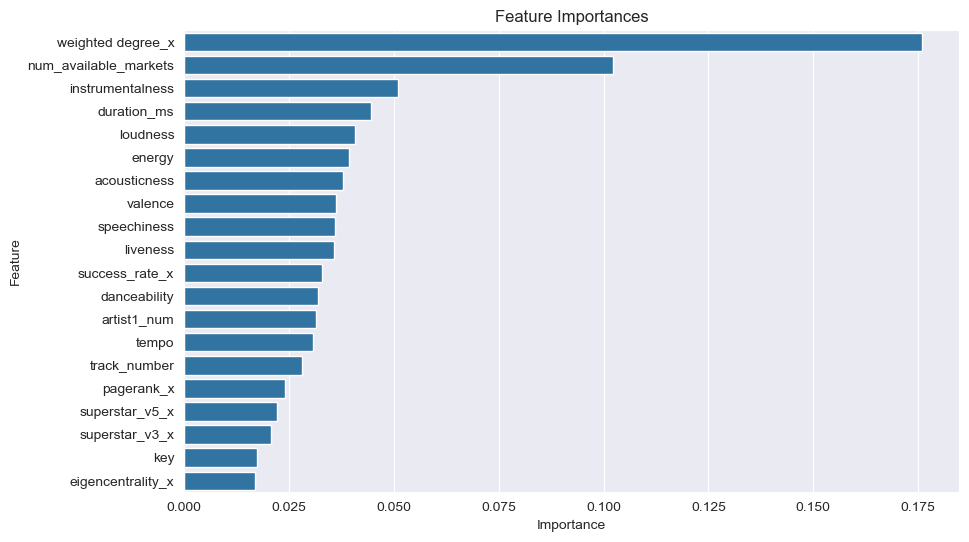

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the Random Forest classifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train_df, y_train_df)

# Get the feature importances
importances = clf2.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.iloc[0:20])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=10)
# plt.tight_layout()

plt.show()


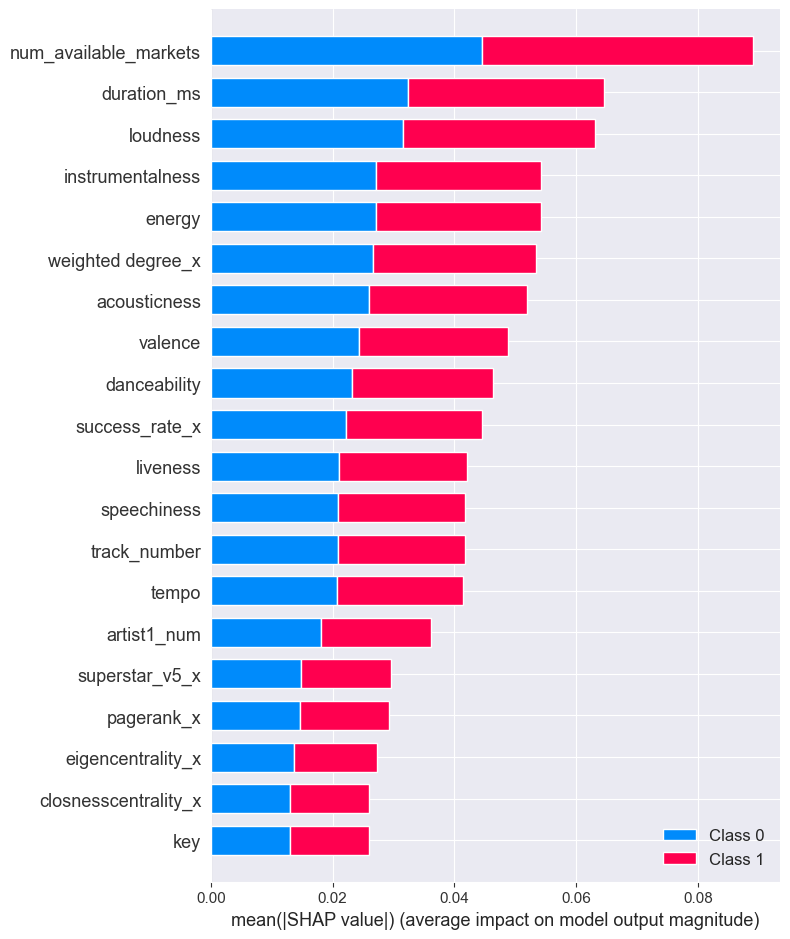

In [16]:
explainer = shap.TreeExplainer(clf2)
shap_values = explainer.shap_values(X_train_df.iloc[:1000])

# Plot the summary plot
shap.summary_plot(shap_values, X_train_df, feature_names=X_train_df.columns)

In [ ]:
explainer = shap.TreeExplainer(clf2)
shap_values = explainer.shap_values(X_train_df.iloc[:10000])

# Plot the summary plot
shap.summary_plot(shap_values, X_train_df, feature_names=X_train_df.columns)